In [3]:
from importlib import reload
import sys
sys.path += ["/home/jacopo.lenti/Projects/learning-od-step-by-step/src"]
import opinion_dynamics_models_estimation as oe
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from tqdm import tqdm
import numpy as np
import repeat_function

In [4]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [264]:
N,T,edge_per_t = 100, 64, 16

model_name = "simple_BC"

evidences_per_t = 8

optimizer_name = "nadam"

lr, num_epochs = 0.1, 200   
epsilon0 = 0.25
epsilon, mu, rho = parameters = 0.34, 0.23, 16
hide_progress = False
minibatch_size = 0

patience, min_delta, min_epochs, sample_pairs = 20, 1e-6, 20, 50

In [265]:
X, edges, evidences = oe.simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))

In [266]:
history = oe.estimation_BC_model_from_data(X, edges, evidences, parameters,
                                           epsilon0, model_name,optimizer_name,
                                           lr, num_epochs, hide_progress, patience, min_delta, minibatch_size,
                                           min_epochs, sample_pairs, summarized = False)

 30%|████████████████████████████▏                                                                 | 60/200 [00:00<00:00, 1304.53it/s]


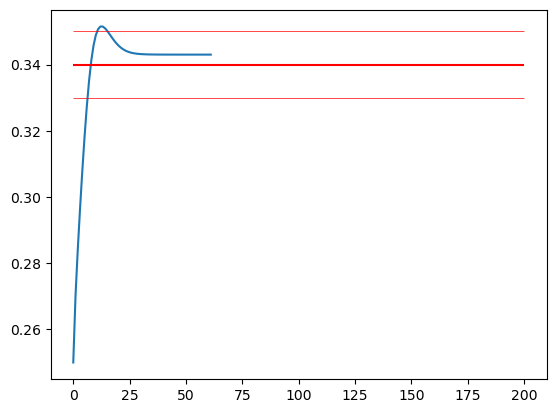

In [267]:
plt.plot(history["epsilon"])
plt.hlines(epsilon, xmin = 0, xmax = num_epochs, colors = "red")
plt.hlines([epsilon + 0.01, epsilon - 0.01], xmin = 0, xmax = num_epochs, colors = "red", lw = 0.5)

## Hyperparameter settings

In [22]:
import json

json.dump(hyperparams_simple_BC, open("../data/hyperparams_simple_bc.json", 'w'))
json.dump(hyperparams_obs_pos_BC, open("../data/hyperparams_obs_pos_bc.json", 'w'))
json.dump(hyperparams_evidence_BC, open("../data/hyperparams_evidence_bc.json", 'w'))
json.dump(hyperparams_backfire_BC, open("../data/hyperparams_backfire_bc.json", 'w'))

In [18]:
hyperparams_simple_BC = {"model_name": "simple_BC",
                         "optimizer_name": "nadam",
                         "lr": 0.1,
                         "minibatch_size": 0,
                         "num_epochs": 200,
                         "epsilon0": 0.25,
                         "sample_pairs":  50,
                         "summarized": True,
                         "early_stopping_kw": {"patience": 20, "min_delta": 1e-5,
                                               "min_epochs": 20, "long_run_delta": 1e-4, 
                                               "long_run_diff":20, "long_run_patience": 10}
                        }

In [19]:
hyperparams_obs_pos_BC = {"model_name": "BC_observed_positive",
                          "optimizer_name": "adam",
                          "lr": 0.05,
                          "minibatch_size": 0,
                          "num_epochs": 200,
                          "epsilon0": 0.25,
                          "early_stopping_kw": {"patience": 20, "min_delta": 1e-5,
                                               "min_epochs": 20, "long_run_delta": 1e-4, 
                                               "long_run_diff":20, "long_run_patience": 10},
                          "sample_pairs":  50, 
                          "summarized": True
                         }

In [20]:
hyperparams_evidence_BC = {"model_name": "BC_with_evidence",
                           "optimizer_name": "RMSprop",
                           "lr": 0.05,
                           "minibatch_size": 0,
                           "num_epochs": 200,
                           "X0_lr_scale": 10,
                           "epsilon0": 0.25,
                          "early_stopping_kw": {"patience": 20, "min_delta": 1e-5,
                                               "min_epochs": 20, "long_run_delta": 1e-3, 
                                               "long_run_diff":20, "long_run_patience": 10}, 
                           "sample_pairs":  50,
                           "summarized": True
                          }

In [21]:
hyperparams_backfire_BC = {"model_name": "BC_backfire",
                           "optimizer_name": "RMSprop",
                           "lr": 0.05,
                           "minibatch_size": 0,
                           "num_epochs": 200,
                           "epsilon0_plus": 0.25,
                           "epsilon0_minus": 0.75,
                           "X0_lr_scale": 10,
                           "early_stopping_kw": {"patience": 20, "min_delta": 1e-5,
                                                 "min_epochs": 20, "long_run_delta": 1e-3, 
                                                 "long_run_diff":20, "long_run_patience": 10},
                           "sample_pairs":  50,
                           "summarized": True
                          }

## Simple_BC

In [280]:
repetitions = 24

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N":100, "parameters": [epsilon, mu, rho], "evidences_per_t": 8
                                                      }, 
                                                      {"edge_per_t": [1,4,16,64],
                                                       "T": [16, 32, 64, 128, 256]},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {**hyperparams_simple_BC},
                                                      {}, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = False
                               )


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:48<00:00,  2.03s/it]


In [288]:
cals_simple_bc_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"] -  x["epsilon_estimated"]))\
.assign(early_stopping = lambda x: x["num_epochs"])

In [306]:
#cals_simple_bc_df.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/cal_pgabms_simple_BC_230721.csv", index = None)
#cals_pos_obs_df.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/cal_pgabms_obs_pos_BC_230721.csv", index = None)
#cals_bc_evidences_df.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/cal_pgabms_evidences_230721.csv", index = None)

<AxesSubplot:xlabel='edge_per_t', ylabel='distance_epsilon'>

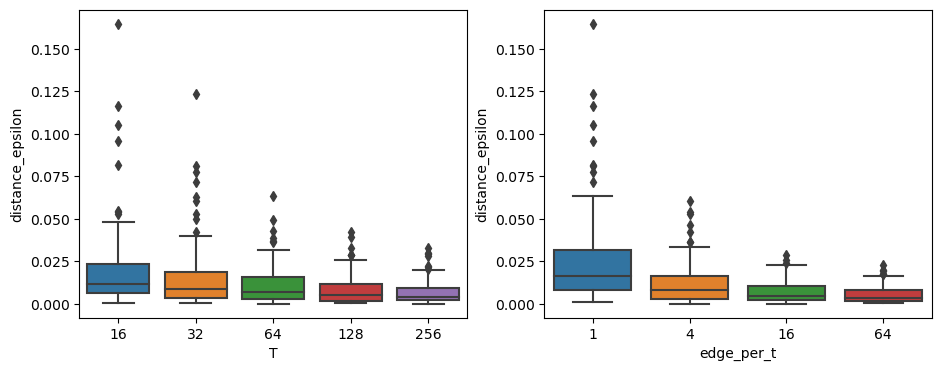

In [289]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 4))

sns.boxplot(data = cals_simple_bc_df, x = "T", y = "distance_epsilon", ax = axes[0])
sns.boxplot(data = cals_simple_bc_df, x = "edge_per_t", y = "distance_epsilon", ax = axes[1])

<AxesSubplot:xlabel='T', ylabel='edge_per_t'>

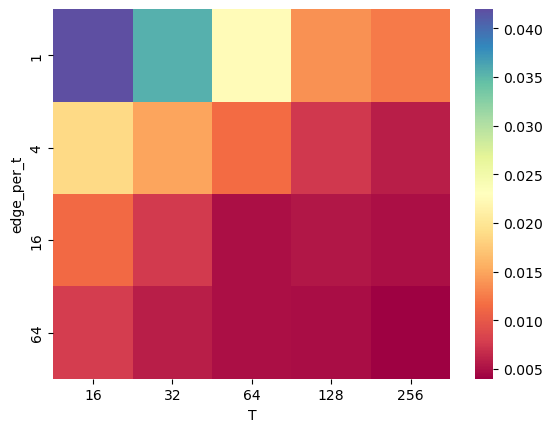

In [290]:
sns.heatmap(cals_simple_bc_df.groupby(["edge_per_t", "T"]).mean()["distance_epsilon"].unstack(), cmap = "Spectral")

<AxesSubplot:xlabel='mu', ylabel='distance_epsilon'>

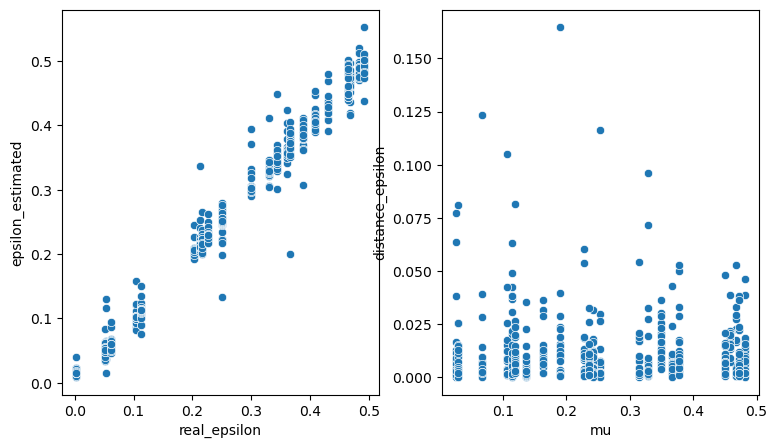

In [292]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 5))

sns.scatterplot(data = cals_simple_bc_df, x = "real_epsilon", y = "epsilon_estimated", ax = axes[0])
sns.scatterplot(data = cals_simple_bc_df, x = "mu", y = "distance_epsilon", ax = axes[1])

## Observed_positive_BC

In [293]:
repetitions = 24

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N":100, "parameters": [epsilon, mu, rho], "evidences_per_t": 8
                                                      }, 
                                                      {"edge_per_t": [1,4,16,64],
                                                       "T": [16, 32, 64, 128, 256]},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {**hyperparams_obs_pos_BC},
                                                      {}, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = False
                               )


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [17:49<00:00, 44.54s/it]


In [294]:
cals_pos_obs_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"] -  x["epsilon_estimated"]))\
.assign(early_stopping = lambda x: x["num_epochs"])

<AxesSubplot:xlabel='edge_per_t', ylabel='distance_epsilon'>

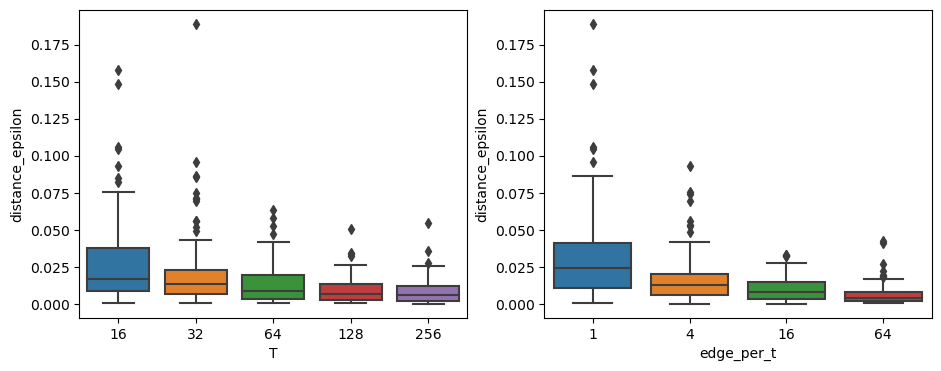

In [295]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 4))

sns.boxplot(data = cals_pos_obs_df, x = "T", y = "distance_epsilon", ax = axes[0])
sns.boxplot(data = cals_pos_obs_df, x = "edge_per_t", y = "distance_epsilon", ax = axes[1])

<AxesSubplot:xlabel='T', ylabel='edge_per_t'>

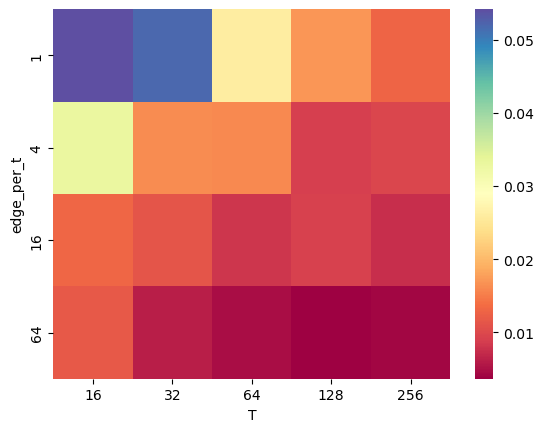

In [296]:
sns.heatmap(cals_pos_obs_df.groupby(["edge_per_t", "T"]).mean()["distance_epsilon"].unstack(), cmap = "Spectral")

<AxesSubplot:xlabel='mu', ylabel='distance_epsilon'>

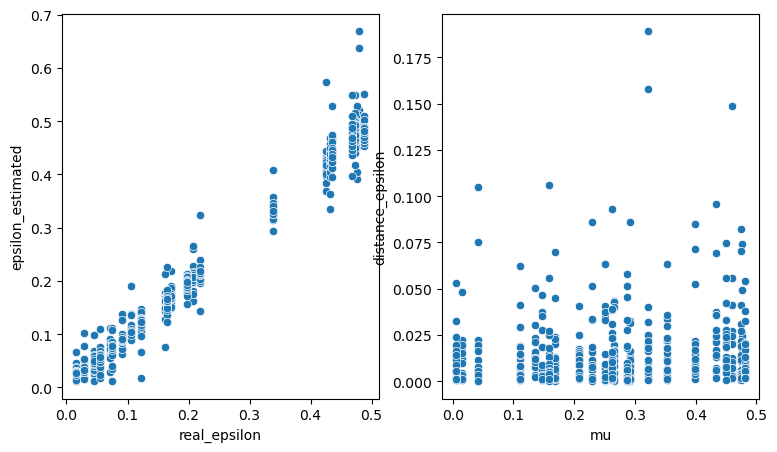

In [297]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 5))

sns.scatterplot(data = cals_pos_obs_df, x = "real_epsilon", y = "epsilon_estimated", ax = axes[0])
sns.scatterplot(data = cals_pos_obs_df, x = "mu", y = "distance_epsilon", ax = axes[1])

## BC_with_evidences

In [298]:
repetitions = 24

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N":100, "parameters": [epsilon, mu, rho]}, 
                                                      {"edge_per_t": [1,4,16,64],
                                                       "T": [16, 32, 64, 128, 256],
                                                       "evidences_per_t": [2,4,8,16]},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {**hyperparams_evidence_BC},
                                                      {}, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = False
                               )


100%|████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [11:25:24<00:00, 1713.53s/it]


In [300]:
cals_bc_evidences_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"] -  x["epsilon_estimated"]))#\
#.assign(early_stopping = lambda x: x["num_epochs"])

<AxesSubplot:xlabel='evidences_per_t', ylabel='distance_epsilon'>

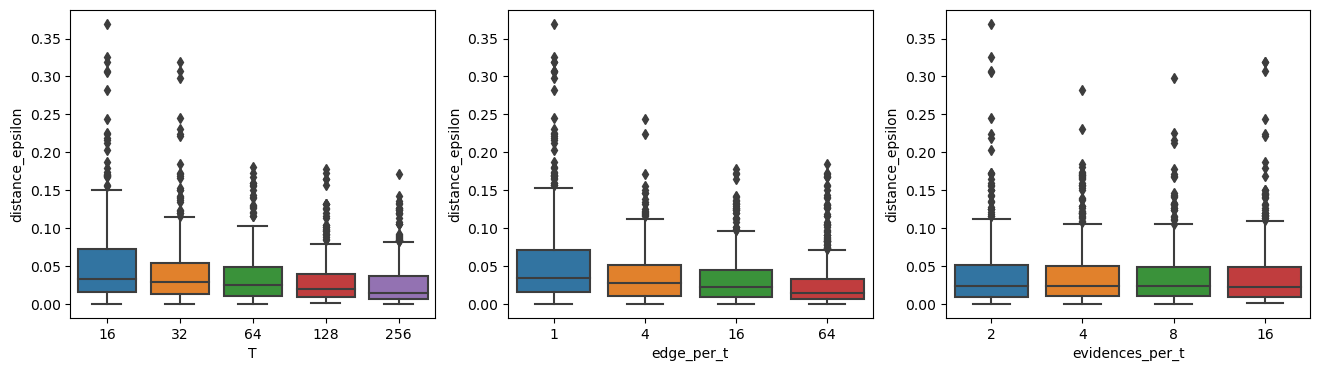

In [301]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

sns.boxplot(data = cals_bc_evidences_df, x = "T", y = "distance_epsilon", ax = axes[0])
sns.boxplot(data = cals_bc_evidences_df, x = "edge_per_t", y = "distance_epsilon", ax = axes[1])
sns.boxplot(data = cals_bc_evidences_df, x = "evidences_per_t", y = "distance_epsilon", ax = axes[2])

<AxesSubplot:xlabel='T', ylabel='edge_per_t'>

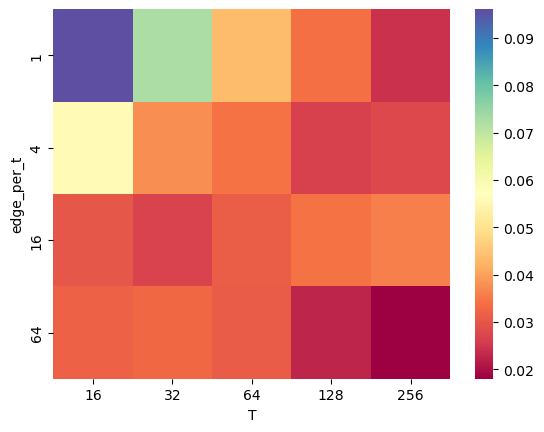

In [302]:
sns.heatmap(cals_bc_evidences_df.groupby(["edge_per_t", "T"]).mean()["distance_epsilon"].unstack(), cmap = "Spectral")

<AxesSubplot:xlabel='T', ylabel='evidences_per_t'>

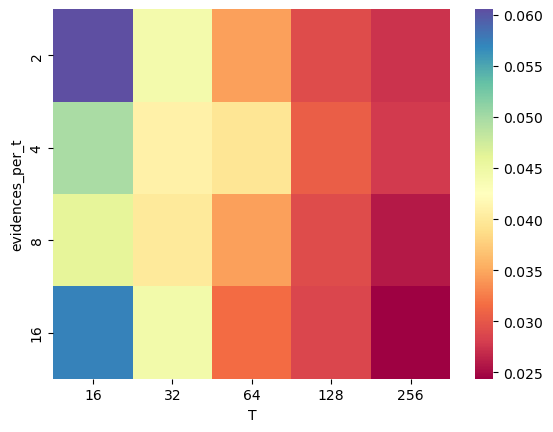

In [303]:
sns.heatmap(cals_bc_evidences_df.groupby(["evidences_per_t", "T"]).mean()["distance_epsilon"].unstack(), cmap = "Spectral")

In [309]:
cals_bc_evidences_df.mean()["distance_epsilon"]

0.03729927132753445

<AxesSubplot:xlabel='mu', ylabel='distance_epsilon'>

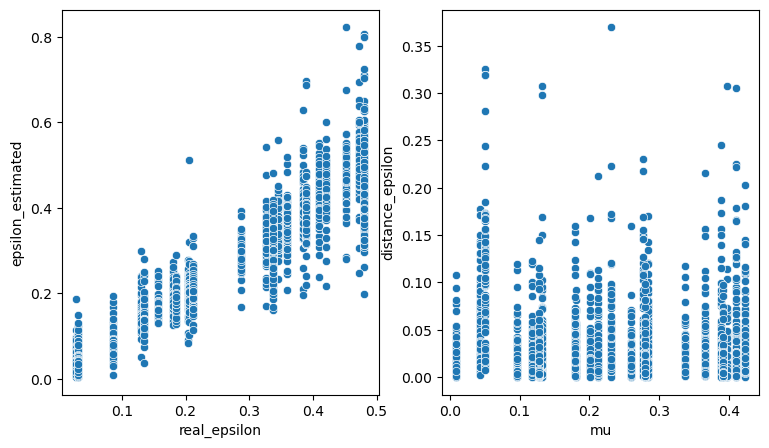

In [304]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 5))

sns.scatterplot(data = cals_bc_evidences_df, x = "real_epsilon", y = "epsilon_estimated", ax = axes[0])
sns.scatterplot(data = cals_bc_evidences_df, x = "mu", y = "distance_epsilon", ax = axes[1])